# Simulation - Varying Ethereum gas fees

#### Maria Silva, March 2024

## Load & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

In [3]:
from redsim.params import Params
from redsim.sim import run_mc_sim

## Set paramaters

In [4]:
sim_len = int(30 * 60 * 60 * 24 / 12)  # 30 day of ETH blocks
sim_iter = 1000  # MC paths

params = Params()
params.set_default_params()

scenario_name_list = ["Default gas fees", "Double gas fees", "Half gas fees"]
l1_base_fee_loc_list = [6.3, 2*6.3, int(0.5*6.3)]
l1_prio_scale_list = [80.0, 2*80.0, int(0.5*80.0)]

## Run full MC simulation

In [5]:
sim_df = pd.DataFrame()

for i in range(3):
    # set paramters
    l1_base_fee_loc = l1_base_fee_loc_list[i]
    params.set_param("l1_base_fee_loc", l1_base_fee_loc)
    l1_prio_scale = l1_prio_scale_list[i]
    params.set_param("l1_prio_scale", l1_prio_scale)
    # run sim
    temp_df = run_mc_sim(sim_len, sim_iter, params, agg_daily = True)
    temp_df["scenario"] = scenario_name_list[i]
    sim_df = pd.concat([sim_df, temp_df], ignore_index=True)
    
sim_df.to_csv("../data/sim_gas_fees_output.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.37it/s]


## Analyse results

In [6]:
sim_df = pd.read_csv("../data/sim_gas_fees_output.csv")
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              90000 non-null  object 
 1   onchain_profit_eth     90000 non-null  float64
 2   onchain_profit_usd     90000 non-null  float64
 3   total_profit_eth       90000 non-null  float64
 4   total_profit_usd       90000 non-null  float64
 5   op_rev_share_cost_eth  90000 non-null  float64
 6   l1_base_fee_gwei       90000 non-null  float64
 7   l1_prio_fee_gwei       90000 non-null  float64
 8   l2_base_fee_gwei       90000 non-null  float64
 9   l2_prio_fee_gwei       90000 non-null  float64
 10  l2_gas                 90000 non-null  float64
 11  da_challenge           90000 non-null  float64
 12  infra_cost_usd         90000 non-null  float64
 13  revenue_eth            90000 non-null  float64
 14  revenue_data_eth       90000 non-null  float64
 15  re

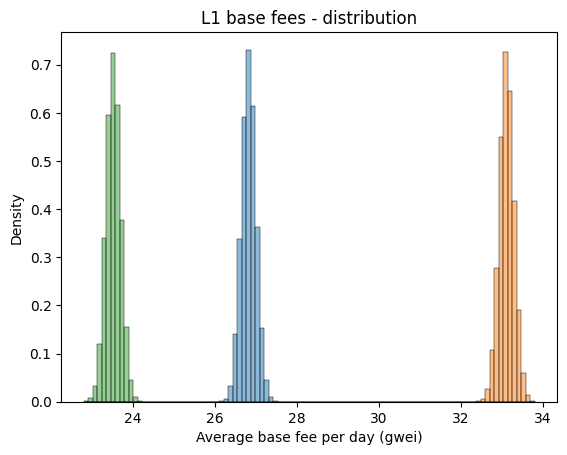

In [7]:
g = sns.histplot(data=sim_df, x="l1_base_fee_gwei", hue="scenario", stat="density", bins=100, legend=False)
plt.title("L1 base fees - distribution")
plt.xlabel('Average base fee per day (gwei)')
plt.ylabel('Density')
plt.show()

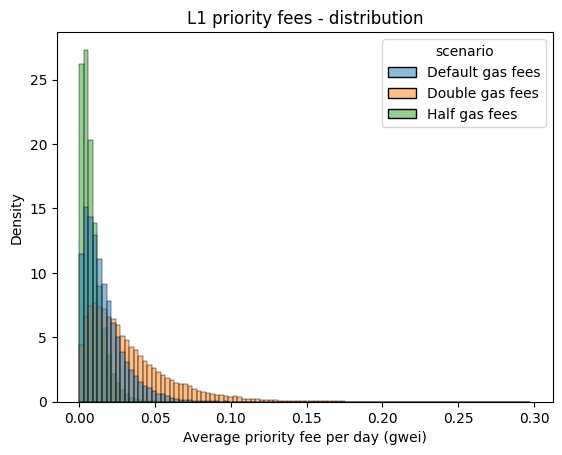

In [8]:
g = sns.histplot(data=sim_df, x="l1_prio_fee_gwei", hue="scenario", stat="density", bins=100)
plt.title("L1 priority fees - distribution")
plt.xlabel('Average priority fee per day (gwei)')
plt.ylabel('Density')
plt.show()

In [9]:
temp_df = (
    sim_df[sim_df["timestamp"]==sim_df["timestamp"].max()] # get last day of sim
    .groupby("scenario")
    [["onchain_profit_eth", "total_profit_eth", "op_rev_share_cost_eth", "onchain_profit_usd", "total_profit_usd"]]
    .agg(["mean", "std"])
    .round(2)
)
temp_df

onchain_profit_eth       total_profit_eth        \
                               mean   std             mean   std   
scenario                                                           
Default gas fees              78.21  0.48            62.42  0.41   
Double gas fees               96.11  0.58            77.63  0.49   
Half gas fees                 68.85  0.45            54.46  0.39   

                 op_rev_share_cost_eth       onchain_profit_usd           \
                                  mean   std               mean      std   
scenario                                                                   
Default gas fees                 11.73  0.07          195517.48  1205.48   
Double gas fees                  14.42  0.09          240272.93  1446.10   
Half gas fees                    10.33  0.07          172132.79  1136.57   

                 total_profit_usd           
                             mean      std  
scenario                                    
Default gas fees        156037.96  1024.72  
Double gas fees         194080.25  1229.02  
Half gas fees           136160.88   966.08

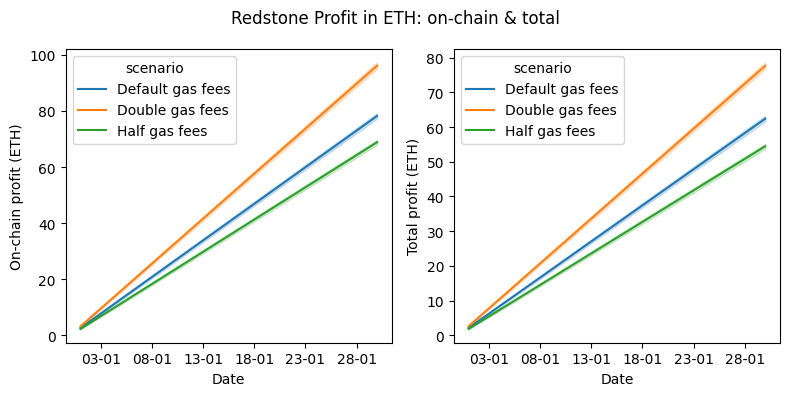

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=sim_df, x="timestamp", y="onchain_profit_eth", hue="scenario", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=sim_df, x="timestamp", y="total_profit_eth",hue="scenario", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

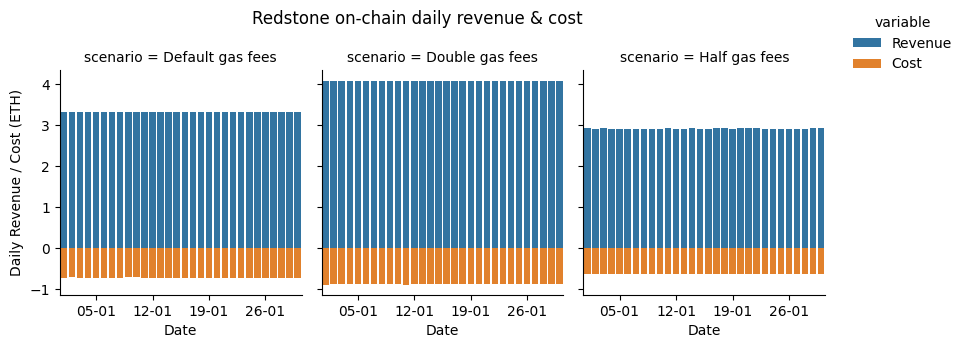

In [11]:
temp_df = sim_df.copy()
temp_df["Revenue"] = temp_df["revenue_eth"]
temp_df["Cost"] = -temp_df["onchain_cost_eth"]
temp_df = temp_df.melt(id_vars=["timestamp", "scenario"], value_vars=["Revenue", "Cost"])

g = sns.catplot(data=temp_df, x="timestamp", y="value", hue="variable", col="scenario", 
                kind="bar", height=3.5, aspect=0.7, estimator="mean", errorbar=None, dodge=False)
g.set(xlabel="Date", ylabel="Daily Revenue / Cost (ETH)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("Redstone on-chain daily revenue & cost")
plt.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [12]:
temp_df = (
    sim_df
    .groupby("scenario")
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .round(3)
)
temp_df

revenue_data_eth        revenue_exec_eth         \
                             mean    std             mean    std   
scenario                                                           
Default gas fees            3.257  0.095            0.066  0.003   
Double gas fees             4.023  0.112            0.066  0.003   
Half gas fees               2.857  0.088            0.066  0.003   

                 batcher_gas_cost_eth        proposer_gas_cost_eth         \
                                 mean    std                  mean    std   
scenario                                                                    
Default gas fees                0.645  0.014                 0.059  0.007   
Double gas fees                 0.796  0.016                 0.072  0.007   
Half gas fees                   0.565  0.014                 0.051  0.007   

                 da_gas_cost_eth         
                            mean    std  
scenario                                 
Default gas fees           0.013  0.019  
Double gas fees            0.017  0.022  
Half gas fees              0.012  0.017

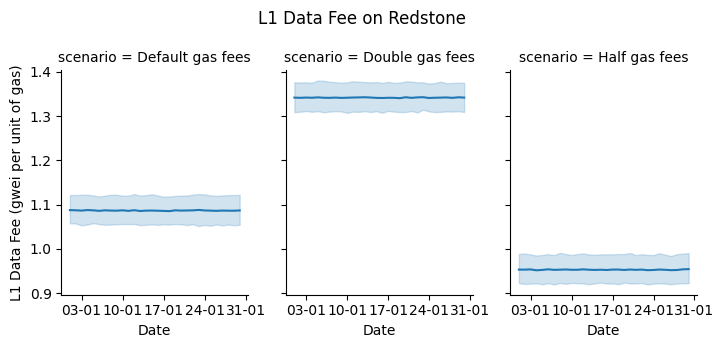

In [13]:
temp_df = sim_df.copy()
temp_df["l1_data_fee_cost"] = temp_df["revenue_data_eth"] / temp_df["l2_gas"]
temp_df["l1_data_fee_cost_gwei"] = temp_df["l1_data_fee_cost"]/0.000000001

g = sns.relplot(data=temp_df, x="timestamp", y="l1_data_fee_cost_gwei", col="scenario", 
                kind="line", height=3.5, aspect=0.7, errorbar="pi")
g.set(xlabel="Date", ylabel="L1 Data Fee (gwei per unit of gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L1 Data Fee on Redstone")
plt.tight_layout()
plt.show()

0.022052514850014027


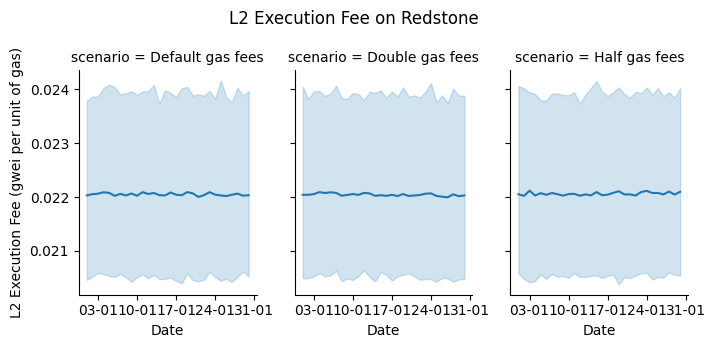

In [14]:
temp_df = sim_df.copy()
temp_df["exec_fee_cost"] = temp_df["revenue_exec_eth"] / temp_df["l2_gas"]
temp_df["exec_fee_cost_gwei"] = temp_df["exec_fee_cost"]/0.000000001
print(temp_df["exec_fee_cost_gwei"].mean())

g = sns.relplot(data=temp_df, x="timestamp", y="exec_fee_cost_gwei", col="scenario", 
                kind="line", height=3.5, aspect=0.7, errorbar="pi")
g.set(xlabel="Date", ylabel="L2 Execution Fee (gwei per unit of gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L2 Execution Fee on Redstone")
plt.tight_layout()
plt.show()

## Quick test - what happens when fee prices decrease significantly? 

In [34]:
# define settings
sim_len = int(30 * 60 * 60 * 24 / 12)  # 30 day of ETH blocks
sim_iter = 1000  # MC paths
scale_factor = 0.01

# set parameters
params = Params()
params.set_default_params()
l1_base_fee_loc = 6.3 * scale_factor
l1_base_fee_scale = 11.4 * scale_factor
l1_prio_scale = 80 * scale_factor
params.set_param("l1_base_fee_loc", l1_base_fee_loc)
params.set_param("l1_base_fee_scale", l1_base_fee_scale)
params.set_param("l1_prio_scale", l1_prio_scale)
# run sim
test_df = run_mc_sim(sim_len, sim_iter, params, agg_daily = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:44<00:00,  6.10it/s]


In [35]:
temp_df = (
    test_df[test_df["timestamp"]==test_df["timestamp"].max()] # get last day of sim
    [["onchain_profit_eth", "total_profit_eth", "op_rev_share_cost_eth", "onchain_profit_usd", "total_profit_usd"]]
    .agg(["mean", "std"])
    .round(2)
    .T
)
temp_df

,mean,std
onchain_profit_eth,2.75,0.02
total_profit_eth,-1.73,0.02
op_rev_share_cost_eth,0.41,0.00
onchain_profit_usd,6866.60,49.47
total_profit_usd,-4315.41,42.24


In [36]:
temp_df = (
    test_df
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .round(3)
    .T
)
temp_df

,mean,std
revenue_data_eth,0.033,0.001
revenue_exec_eth,0.066,0.003
batcher_gas_cost_eth,0.006,0.000
proposer_gas_cost_eth,0.001,0.000
da_gas_cost_eth,0.000,0.000


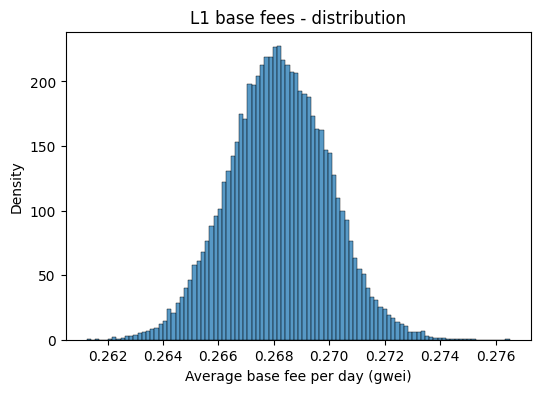

In [37]:
fig, ax = plt.subplots(figsize=(6,4))
g = sns.histplot(data=test_df, x="l1_base_fee_gwei", stat="density", bins=100)
plt.title("L1 base fees - distribution")
plt.xlabel('Average base fee per day (gwei)')
plt.ylabel('Density')
plt.show()

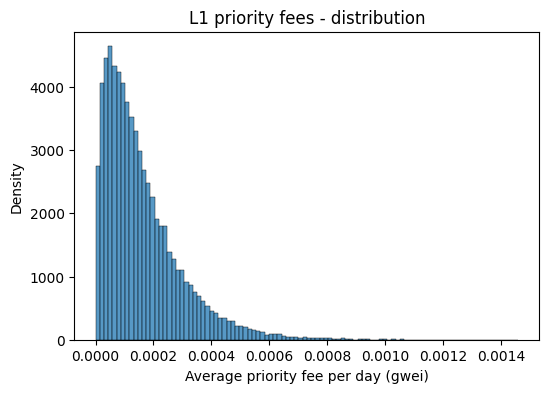

In [38]:
fig, ax = plt.subplots(figsize=(6,4))
g = sns.histplot(data=test_df, x="l1_prio_fee_gwei", stat="density", bins=100)
plt.title("L1 priority fees - distribution")
plt.xlabel('Average priority fee per day (gwei)')
plt.ylabel('Density')
plt.show()

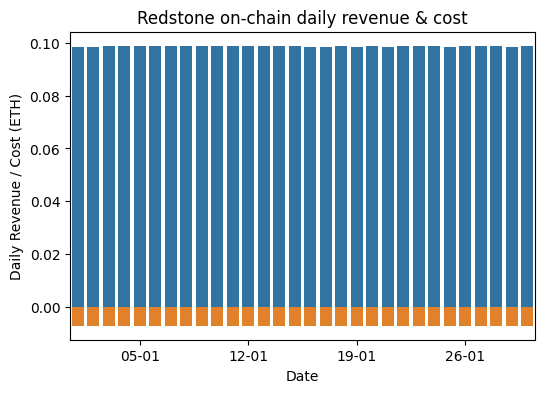

In [39]:
temp_df = test_df.copy()
temp_df["revenue_eth"] = temp_df["revenue_eth"]
temp_df["onchain_cost_eth"] = -temp_df["onchain_cost_eth"]

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(temp_df, x="timestamp", y="revenue_eth", estimator="mean", errorbar=None)
sns.barplot(temp_df, x="timestamp", y="onchain_cost_eth", estimator="mean", errorbar=None)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel("Date")
plt.ylabel("Daily Revenue / Cost (ETH)")
plt.title("Redstone on-chain daily revenue & cost")
plt.show()